# Elaborating multiple annotators noise for non unequal image sized with U-NET and t-SNE

## Training a neural network for handling the feature extraction

In [2]:
# Install external libraries

!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git >> /tmp/null
!pip install wandb >> /tmp/null

  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git /tmp/pip-req-build-g38wwem7


In [3]:
# Native libraries
import os
import random
import warnings
from enum import auto, Enum
from functools import partial

# General use libraries
import numpy as np
import matplotlib.pyplot as plt

# External libraries #

# OpenCV librarie
import cv2

# Sklearn librarie and modules
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Tensorflow librarie and modules
import tensorflow as tf
from tensorflow import keras
from matplotlib.style import available
from tensorflow.keras.losses import Loss
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Metric
from tensorflow.keras.utils import to_categorical
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.keras import Model, layers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, Callback

# WanDB librarie and modules
import wandb
from wandb.keras import WandbCallback
from wandb.sklearn import plot_learning_curve

# GCPDS librarie and modules
from gcpds.image_segmentation.models import unet_baseline
from gcpds.image_segmentation.visualizations import plot_contour
from gcpds.image_segmentation.datasets.segmentation import OxfordIiitPet

In [9]:
dataset = OxfordIiitPet()
train_dataset, val_dataset, test_dataset = dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVYPVJJ/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVYPVJJ/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [10]:
BATCH_SIZE = 32
NUM_EPOCHS = 150
TARGET_SHAPE = 256, 256

def fussion_mask(mask: EagerTensor)->EagerTensor:
  obj, bg, border = tf.unstack(mask, axis=2)
  orig_shape = mask.shape
  new_shape = list(orig_shape)
  new_shape[-1] = 1
  return tf.reshape(tf.stack([obj + border]), new_shape)

def map_dataset(dataset, target_shape, batch_size):
    dataset_ = dataset.map(lambda img,mask,label,id_img: (img,mask),
                                      num_parallel_calls=tf.data.AUTOTUNE)
    dataset_ = dataset_.map(lambda img,mask: (tf.image.resize(img,target_shape), tf.image.resize(mask,target_shape)),
                                    num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img,mask: (img, fussion_mask(mask)),
                           num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.batch(batch_size)
    return dataset_


train = map_dataset(train_dataset, TARGET_SHAPE, BATCH_SIZE)
val = map_dataset(val_dataset, TARGET_SHAPE, BATCH_SIZE)
test = map_dataset(test_dataset, TARGET_SHAPE, BATCH_SIZE)

(32, 256, 256, 1)


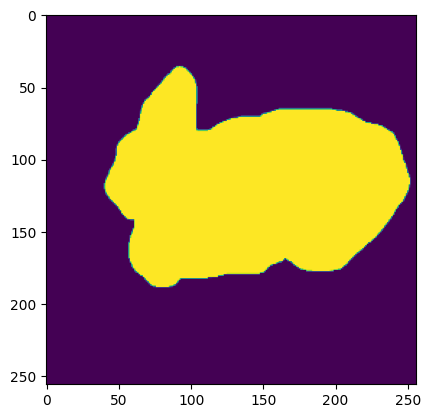

In [11]:
for img,mask in train.take(1):
  print(mask.shape)
  plt.figure()
  plt.imshow(mask[0][:,:,0])

In [4]:
# Definition of the DiceCoefficientLoss

class DiceCoefficient(Loss):
    
    """
    DiceCoefficient loss function.

    This loss function computes the Dice coefficient, a similarity metric commonly
    used in image segmentation tasks. It measures the overlap between the predicted
    segmentation mask (y_pred) and the ground truth mask (y_true).
    
    Methods
    ----------
    call(y_true, y_pred)
    get_config()
    """
    
    def __init__(self, smooth=1., target_class= None, name='DiceCoefficient', **kwargs):
        """
        Initializes the DiceCoefficient loss object.

        Parameters:
            smooth (float): A smoothing parameter to avoid division by zero. Defaults to 1.0.
            target_class (int or None): If specified, computes the Dice coefficient only for 
                the specified class index. If None, computes the average Dice coefficient 
                across all classes. Defaults to None.
            name (str): Name of the loss function. Defaults to 'DiceCoefficient'.
            **kwargs: Additional arguments passed to the parent class.
        """
        self.smooth = smooth
        self.target_class = target_class
        super().__init__(name=name,**kwargs)

    def call(self, y_true, y_pred):
        """
        Computes the Dice coefficient loss.

        Parameters:
            y_true (tensor): Ground truth segmentation masks.
            y_pred (tensor): Predicted segmentation masks.

        Returns:
            A tensor representing the Dice coefficient loss.
        """
        intersection = K.sum(y_true * y_pred, axis=[1,2])
        union = K.sum(y_true,axis=[1,2]) + K.sum(y_pred,axis=[1,2])
        dice_coef = -(2. * intersection + self.smooth) /(union + self.smooth)

        if self.target_class != None:
            dice_coef = tf.gather(dice_coef,
                                  self.target_class, axis=1)
        else:
            dice_coef = K.mean(dice_coef,axis=-1)

        return dice_coef

    def get_config(self,):
        """
        Gets the configuration of the loss function.

        Returns:
            A dictionary containing the configuration parameters of the loss function.
        """
        base_config = super().get_config()
        return {**base_config, "smooth": self.smooth,
                "target_class":self.target_class}

In [21]:
# Definition of the DiceCoefficientMetric

def dice_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5):
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis)
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

In [22]:
# Definition of the JaccardMetric

def jaccard_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5):
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(jaccard)

In [23]:
# Definition of the SensitivityMetric

def sensitivity_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5):
    true_positives = tf.reduce_sum(y_true * y_pred, axis=axis)
    actual_positives = tf.reduce_sum(y_true, axis=axis)
    sensitivity = true_positives / (actual_positives + tf.keras.backend.epsilon())
    return tf.reduce_mean(sensitivity)

In [24]:
# Definition of the SpecificityMetric

def specificity_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5):
    true_negatives = tf.reduce_sum((1 - y_true) * (1 - y_pred), axis=axis)
    actual_negatives = tf.reduce_sum(1 - y_true, axis=axis)
    specificity = true_negatives / (actual_negatives + tf.keras.backend.epsilon())
    return tf.reduce_mean(specificity)

In [16]:
# WanDB Credentianls for login (optional)
wandb_active = True
wandb.login(key="YourWanDBAPIKey")

# Definition metrics to record with WanDB

class WandbCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Records the Loss value and metrics at the end of each epoch
        wandb.log({'Epoch': epoch, 'Loss': logs['loss'], 'Jaccard': logs['jaccard_metric'], 'Sensitivity': logs['sensitivity_metric'], 
                   'Specificity': logs['specificity_metric'], 'Dice': logs['dice_metric'], 
                   'val_Loss': logs['val_loss'], 'val_Jaccard': logs['val_jaccard_metric'], 'val_Sensitivity': logs['val_sensitivity_metric'],
                  'val_Specificity': logs['val_specificity_metric'],'val_Dice': logs['val_dice_metric']})

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [25]:
model = unet_baseline(input_shape= TARGET_SHAPE + (3,), out_channels=1)
model.compile(
    loss=DiceCoefficient(),
    optimizer="adam",
    metrics = [dice_metric, jaccard_metric, sensitivity_metric, specificity_metric]
    )
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch00             │ (None, 256, 256,  │         12 │ input_layer_1[0]… │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv10 (Conv2D)     │ (None, 256, 256,  │        224 │ Batch00[0][0]     │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch10             │ (None, 256, 256,  │         32 │ Conv10[0][0]      │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv11 (Conv2D)     │ (None, 256, 256,  │        584 │ Batch10[0][0]     │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch11             │ (None, 256, 256,  │         32 │ Conv11[0][0]      │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pool10              │ (None, 128, 128,  │          0 │ Batch11[0][0]     │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv20 (Conv2D)     │ (None, 128, 128,  │      1,168 │ Pool10[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch20             │ (None, 128, 128,  │         64 │ Conv20[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv21 (Conv2D)     │ (None, 128, 128,  │      2,320 │ Batch20[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch22             │ (None, 128, 128,  │         64 │ Conv21[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pool20              │ (None, 64, 64,    │          0 │ Batch22[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv30 (Conv2D)     │ (None, 64, 64,    │      4,640 │ Pool20[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch30             │ (None, 64, 64,    │        128 │ Conv30[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv31 (Conv2D)     │ (None, 64, 64,    │      9,248 │ Batch30[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch31             │ (None, 64, 64,    │        128 │ Conv31[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pool30              │ (None, 32, 32,    │          0 │ Batch31[0][0]   

 Total params: 494,093 (1.88 MB)

 Trainable params: 492,615 (1.88 MB)

 Non-trainable params: 1,478 (5.77 KB)

In [ ]:
if wandb_active == True:
    run = wandb.init(project='YourProjectName', entity='YourEntity')
    wandb.config.dataset_name = "OxfordPets"
    wandb.config.architecture_name = "UNet-OxfordPets"
    model.fit(train,validation_data=val,epochs=NUM_EPOCHS,callbacks=[WandbCallback()])
    model.save(f'{model.name}.h5')
    wandb.save(f'{model.name}.h5')
    run.finish()
else:
    model.fit(train,validation_data=val,epochs=NUM_EPOCHS)
    model.save(f'{model.name}.h5')

wandb: Currently logged in as: liturriago (gcpds). Use `wandb login --relogin` to force relogin


Epoch 1/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - dice_metric: 0.7525 - jaccard_metric: 0.6190 - loss: -0.7525 - sensitivity_metric: 0.8568 - specificity_metric: 0.7496

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - dice_metric: 0.7527 - jaccard_metric: 0.6200 - loss: -0.7527 - sensitivity_metric: 0.8521 - specificity_metric: 0.7694 - val_dice_metric: 0.0935 - val_jaccard_metric: 0.0534 - val_loss: -0.0936 - val_sensitivity_metric: 0.0573 - val_specificity_metric: 0.9783
Epoch 2/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - dice_metric: 0.7958 - jaccard_metric: 0.6737 - loss: -0.7958 - sensitivity_metric: 0.8683 - specificity_metric: 0.8190

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.7892 - jaccard_metric: 0.6673 - loss: -0.7892 - sensitivity_metric: 0.8622 - specificity_metric: 0.8217 - val_dice_metric: 0.7013 - val_jaccard_metric: 0.5629 - val_loss: -0.7013 - val_sensitivity_metric: 0.7207 - val_specificity_metric: 0.8504
Epoch 3/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.8228 - jaccard_metric: 0.7128 - loss: -0.8228 - sensitivity_metric: 0.8871 - specificity_metric: 0.8416

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - dice_metric: 0.8137 - jaccard_metric: 0.7014 - loss: -0.8137 - sensitivity_metric: 0.8732 - specificity_metric: 0.8467 - val_dice_metric: 0.7807 - val_jaccard_metric: 0.6604 - val_loss: -0.7807 - val_sensitivity_metric: 0.8980 - val_specificity_metric: 0.7743
Epoch 4/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.8398 - jaccard_metric: 0.7363 - loss: -0.8398 - sensitivity_metric: 0.8915 - specificity_metric: 0.8623

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - dice_metric: 0.8282 - jaccard_metric: 0.7213 - loss: -0.8282 - sensitivity_metric: 0.8785 - specificity_metric: 0.8627 - val_dice_metric: 0.7751 - val_jaccard_metric: 0.6563 - val_loss: -0.7751 - val_sensitivity_metric: 0.9541 - val_specificity_metric: 0.6919
Epoch 5/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - dice_metric: 0.8460 - jaccard_metric: 0.7452 - loss: -0.8460 - sensitivity_metric: 0.8910 - specificity_metric: 0.8688

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - dice_metric: 0.8389 - jaccard_metric: 0.7365 - loss: -0.8389 - sensitivity_metric: 0.8810 - specificity_metric: 0.8738 - val_dice_metric: 0.8164 - val_jaccard_metric: 0.7085 - val_loss: -0.8164 - val_sensitivity_metric: 0.9229 - val_specificity_metric: 0.7995
Epoch 6/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.8577 - jaccard_metric: 0.7622 - loss: -0.8577 - sensitivity_metric: 0.8916 - specificity_metric: 0.8880

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - dice_metric: 0.8520 - jaccard_metric: 0.7554 - loss: -0.8520 - sensitivity_metric: 0.8864 - specificity_metric: 0.8889 - val_dice_metric: 0.8258 - val_jaccard_metric: 0.7215 - val_loss: -0.8258 - val_sensitivity_metric: 0.9119 - val_specificity_metric: 0.8291
Epoch 7/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - dice_metric: 0.8642 - jaccard_metric: 0.7711 - loss: -0.8642 - sensitivity_metric: 0.8936 - specificity_metric: 0.8978

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.8569 - jaccard_metric: 0.7622 - loss: -0.8569 - sensitivity_metric: 0.8894 - specificity_metric: 0.8923 - val_dice_metric: 0.8307 - val_jaccard_metric: 0.7293 - val_loss: -0.8307 - val_sensitivity_metric: 0.9197 - val_specificity_metric: 0.8209
Epoch 8/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.8706 - jaccard_metric: 0.7806 - loss: -0.8706 - sensitivity_metric: 0.9004 - specificity_metric: 0.8954

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.8643 - jaccard_metric: 0.7731 - loss: -0.8643 - sensitivity_metric: 0.8965 - specificity_metric: 0.8953 - val_dice_metric: 0.8384 - val_jaccard_metric: 0.7375 - val_loss: -0.8384 - val_sensitivity_metric: 0.8749 - val_specificity_metric: 0.8810
Epoch 9/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.8815 - jaccard_metric: 0.7965 - loss: -0.8815 - sensitivity_metric: 0.9050 - specificity_metric: 0.9067

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - dice_metric: 0.8697 - jaccard_metric: 0.7811 - loss: -0.8697 - sensitivity_metric: 0.8967 - specificity_metric: 0.9028 - val_dice_metric: 0.8242 - val_jaccard_metric: 0.7211 - val_loss: -0.8242 - val_sensitivity_metric: 0.9301 - val_specificity_metric: 0.8120
Epoch 10/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.8864 - jaccard_metric: 0.8043 - loss: -0.8864 - sensitivity_metric: 0.9098 - specificity_metric: 0.9110

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - dice_metric: 0.8765 - jaccard_metric: 0.7910 - loss: -0.8765 - sensitivity_metric: 0.9004 - specificity_metric: 0.9088 - val_dice_metric: 0.8327 - val_jaccard_metric: 0.7324 - val_loss: -0.8327 - val_sensitivity_metric: 0.9101 - val_specificity_metric: 0.8353
Epoch 11/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.8873 - jaccard_metric: 0.8070 - loss: -0.8873 - sensitivity_metric: 0.9075 - specificity_metric: 0.9117

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - dice_metric: 0.8824 - jaccard_metric: 0.8002 - loss: -0.8824 - sensitivity_metric: 0.9046 - specificity_metric: 0.9125 - val_dice_metric: 0.8337 - val_jaccard_metric: 0.7345 - val_loss: -0.8337 - val_sensitivity_metric: 0.9129 - val_specificity_metric: 0.8311
Epoch 12/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.8898 - jaccard_metric: 0.8098 - loss: -0.8898 - sensitivity_metric: 0.9058 - specificity_metric: 0.9172

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - dice_metric: 0.8833 - jaccard_metric: 0.8011 - loss: -0.8833 - sensitivity_metric: 0.9026 - specificity_metric: 0.9150 - val_dice_metric: 0.8336 - val_jaccard_metric: 0.7336 - val_loss: -0.8336 - val_sensitivity_metric: 0.8716 - val_specificity_metric: 0.8727
Epoch 13/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.8950 - jaccard_metric: 0.8178 - loss: -0.8950 - sensitivity_metric: 0.9083 - specificity_metric: 0.9227

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - dice_metric: 0.8874 - jaccard_metric: 0.8076 - loss: -0.8874 - sensitivity_metric: 0.9074 - specificity_metric: 0.9168 - val_dice_metric: 0.8127 - val_jaccard_metric: 0.7068 - val_loss: -0.8128 - val_sensitivity_metric: 0.8085 - val_specificity_metric: 0.9079
Epoch 14/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.8966 - jaccard_metric: 0.8208 - loss: -0.8966 - sensitivity_metric: 0.9135 - specificity_metric: 0.9198

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.8946 - jaccard_metric: 0.8186 - loss: -0.8946 - sensitivity_metric: 0.9124 - specificity_metric: 0.9215 - val_dice_metric: 0.8430 - val_jaccard_metric: 0.7472 - val_loss: -0.8430 - val_sensitivity_metric: 0.9132 - val_specificity_metric: 0.8441
Epoch 15/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9051 - jaccard_metric: 0.8331 - loss: -0.9051 - sensitivity_metric: 0.9172 - specificity_metric: 0.9251

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - dice_metric: 0.8986 - jaccard_metric: 0.8245 - loss: -0.8986 - sensitivity_metric: 0.9138 - specificity_metric: 0.9250 - val_dice_metric: 0.8477 - val_jaccard_metric: 0.7531 - val_loss: -0.8477 - val_sensitivity_metric: 0.9238 - val_specificity_metric: 0.8457
Epoch 16/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9121 - jaccard_metric: 0.8439 - loss: -0.9121 - sensitivity_metric: 0.9253 - specificity_metric: 0.9327

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9041 - jaccard_metric: 0.8331 - loss: -0.9041 - sensitivity_metric: 0.9185 - specificity_metric: 0.9299 - val_dice_metric: 0.8435 - val_jaccard_metric: 0.7482 - val_loss: -0.8435 - val_sensitivity_metric: 0.9003 - val_specificity_metric: 0.8576
Epoch 17/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9139 - jaccard_metric: 0.8468 - loss: -0.9139 - sensitivity_metric: 0.9268 - specificity_metric: 0.9312

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - dice_metric: 0.9078 - jaccard_metric: 0.8386 - loss: -0.9078 - sensitivity_metric: 0.9216 - specificity_metric: 0.9308 - val_dice_metric: 0.8531 - val_jaccard_metric: 0.7606 - val_loss: -0.8531 - val_sensitivity_metric: 0.9012 - val_specificity_metric: 0.8714
Epoch 18/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - dice_metric: 0.9217 - jaccard_metric: 0.8593 - loss: -0.9217 - sensitivity_metric: 0.9321 - specificity_metric: 0.9376

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - dice_metric: 0.9136 - jaccard_metric: 0.8478 - loss: -0.9136 - sensitivity_metric: 0.9257 - specificity_metric: 0.9354 - val_dice_metric: 0.8242 - val_jaccard_metric: 0.7213 - val_loss: -0.8242 - val_sensitivity_metric: 0.8067 - val_specificity_metric: 0.9259
Epoch 19/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9238 - jaccard_metric: 0.8627 - loss: -0.9238 - sensitivity_metric: 0.9313 - specificity_metric: 0.9414

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - dice_metric: 0.9164 - jaccard_metric: 0.8522 - loss: -0.9164 - sensitivity_metric: 0.9264 - specificity_metric: 0.9379 - val_dice_metric: 0.8406 - val_jaccard_metric: 0.7430 - val_loss: -0.8406 - val_sensitivity_metric: 0.9208 - val_specificity_metric: 0.8335
Epoch 20/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9220 - jaccard_metric: 0.8596 - loss: -0.9220 - sensitivity_metric: 0.9323 - specificity_metric: 0.9374

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - dice_metric: 0.9151 - jaccard_metric: 0.8500 - loss: -0.9151 - sensitivity_metric: 0.9249 - specificity_metric: 0.9385 - val_dice_metric: 0.7965 - val_jaccard_metric: 0.6890 - val_loss: -0.7965 - val_sensitivity_metric: 0.7500 - val_specificity_metric: 0.9461
Epoch 21/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - dice_metric: 0.9235 - jaccard_metric: 0.8625 - loss: -0.9235 - sensitivity_metric: 0.9291 - specificity_metric: 0.9423

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - dice_metric: 0.9170 - jaccard_metric: 0.8531 - loss: -0.9170 - sensitivity_metric: 0.9260 - specificity_metric: 0.9396 - val_dice_metric: 0.8424 - val_jaccard_metric: 0.7464 - val_loss: -0.8424 - val_sensitivity_metric: 0.8547 - val_specificity_metric: 0.9018
Epoch 22/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9248 - jaccard_metric: 0.8644 - loss: -0.9248 - sensitivity_metric: 0.9298 - specificity_metric: 0.9429

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - dice_metric: 0.9199 - jaccard_metric: 0.8577 - loss: -0.9199 - sensitivity_metric: 0.9279 - specificity_metric: 0.9419 - val_dice_metric: 0.8499 - val_jaccard_metric: 0.7571 - val_loss: -0.8499 - val_sensitivity_metric: 0.9038 - val_specificity_metric: 0.8688
Epoch 23/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9285 - jaccard_metric: 0.8702 - loss: -0.9285 - sensitivity_metric: 0.9345 - specificity_metric: 0.9436

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - dice_metric: 0.9233 - jaccard_metric: 0.8631 - loss: -0.9233 - sensitivity_metric: 0.9306 - specificity_metric: 0.9437 - val_dice_metric: 0.8476 - val_jaccard_metric: 0.7536 - val_loss: -0.8476 - val_sensitivity_metric: 0.8844 - val_specificity_metric: 0.8824
Epoch 24/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9291 - jaccard_metric: 0.8718 - loss: -0.9291 - sensitivity_metric: 0.9333 - specificity_metric: 0.9453

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - dice_metric: 0.9246 - jaccard_metric: 0.8654 - loss: -0.9246 - sensitivity_metric: 0.9313 - specificity_metric: 0.9441 - val_dice_metric: 0.8341 - val_jaccard_metric: 0.7349 - val_loss: -0.8341 - val_sensitivity_metric: 0.8361 - val_specificity_metric: 0.9083
Epoch 25/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - dice_metric: 0.9299 - jaccard_metric: 0.8729 - loss: -0.9299 - sensitivity_metric: 0.9380 - specificity_metric: 0.9439

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - dice_metric: 0.9251 - jaccard_metric: 0.8663 - loss: -0.9251 - sensitivity_metric: 0.9331 - specificity_metric: 0.9442 - val_dice_metric: 0.8354 - val_jaccard_metric: 0.7369 - val_loss: -0.8354 - val_sensitivity_metric: 0.8286 - val_specificity_metric: 0.9162
Epoch 26/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9329 - jaccard_metric: 0.8778 - loss: -0.9329 - sensitivity_metric: 0.9378 - specificity_metric: 0.9454

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - dice_metric: 0.9300 - jaccard_metric: 0.8743 - loss: -0.9300 - sensitivity_metric: 0.9368 - specificity_metric: 0.9474 - val_dice_metric: 0.8428 - val_jaccard_metric: 0.7473 - val_loss: -0.8428 - val_sensitivity_metric: 0.8392 - val_specificity_metric: 0.9176
Epoch 27/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9351 - jaccard_metric: 0.8817 - loss: -0.9351 - sensitivity_metric: 0.9379 - specificity_metric: 0.9493

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9323 - jaccard_metric: 0.8782 - loss: -0.9323 - sensitivity_metric: 0.9379 - specificity_metric: 0.9497 - val_dice_metric: 0.8506 - val_jaccard_metric: 0.7576 - val_loss: -0.8506 - val_sensitivity_metric: 0.8711 - val_specificity_metric: 0.9011
Epoch 28/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9356 - jaccard_metric: 0.8826 - loss: -0.9356 - sensitivity_metric: 0.9426 - specificity_metric: 0.9457

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - dice_metric: 0.9324 - jaccard_metric: 0.8784 - loss: -0.9324 - sensitivity_metric: 0.9391 - specificity_metric: 0.9487 - val_dice_metric: 0.8385 - val_jaccard_metric: 0.7415 - val_loss: -0.8385 - val_sensitivity_metric: 0.8804 - val_specificity_metric: 0.8709
Epoch 29/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - dice_metric: 0.9361 - jaccard_metric: 0.8835 - loss: -0.9361 - sensitivity_metric: 0.9435 - specificity_metric: 0.9467

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - dice_metric: 0.9331 - jaccard_metric: 0.8797 - loss: -0.9331 - sensitivity_metric: 0.9398 - specificity_metric: 0.9497 - val_dice_metric: 0.8465 - val_jaccard_metric: 0.7517 - val_loss: -0.8465 - val_sensitivity_metric: 0.8742 - val_specificity_metric: 0.8927
Epoch 30/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9382 - jaccard_metric: 0.8871 - loss: -0.9382 - sensitivity_metric: 0.9417 - specificity_metric: 0.9515

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9353 - jaccard_metric: 0.8833 - loss: -0.9353 - sensitivity_metric: 0.9404 - specificity_metric: 0.9517 - val_dice_metric: 0.8484 - val_jaccard_metric: 0.7557 - val_loss: -0.8484 - val_sensitivity_metric: 0.9161 - val_specificity_metric: 0.8537
Epoch 31/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9375 - jaccard_metric: 0.8859 - loss: -0.9375 - sensitivity_metric: 0.9420 - specificity_metric: 0.9520

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - dice_metric: 0.9344 - jaccard_metric: 0.8817 - loss: -0.9344 - sensitivity_metric: 0.9398 - specificity_metric: 0.9513 - val_dice_metric: 0.8442 - val_jaccard_metric: 0.7505 - val_loss: -0.8442 - val_sensitivity_metric: 0.8948 - val_specificity_metric: 0.8711
Epoch 32/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9380 - jaccard_metric: 0.8867 - loss: -0.9380 - sensitivity_metric: 0.9429 - specificity_metric: 0.9521

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9336 - jaccard_metric: 0.8805 - loss: -0.9336 - sensitivity_metric: 0.9394 - specificity_metric: 0.9513 - val_dice_metric: 0.8451 - val_jaccard_metric: 0.7501 - val_loss: -0.8451 - val_sensitivity_metric: 0.8672 - val_specificity_metric: 0.8965
Epoch 33/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9384 - jaccard_metric: 0.8872 - loss: -0.9384 - sensitivity_metric: 0.9424 - specificity_metric: 0.9503

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - dice_metric: 0.9367 - jaccard_metric: 0.8855 - loss: -0.9367 - sensitivity_metric: 0.9426 - specificity_metric: 0.9514 - val_dice_metric: 0.8572 - val_jaccard_metric: 0.7677 - val_loss: -0.8572 - val_sensitivity_metric: 0.9019 - val_specificity_metric: 0.8778
Epoch 34/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - dice_metric: 0.9427 - jaccard_metric: 0.8947 - loss: -0.9427 - sensitivity_metric: 0.9443 - specificity_metric: 0.9574

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - dice_metric: 0.9384 - jaccard_metric: 0.8884 - loss: -0.9384 - sensitivity_metric: 0.9428 - specificity_metric: 0.9551 - val_dice_metric: 0.8530 - val_jaccard_metric: 0.7625 - val_loss: -0.8530 - val_sensitivity_metric: 0.8914 - val_specificity_metric: 0.8843
Epoch 35/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9435 - jaccard_metric: 0.8959 - loss: -0.9435 - sensitivity_metric: 0.9482 - specificity_metric: 0.9544

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - dice_metric: 0.9380 - jaccard_metric: 0.8878 - loss: -0.9381 - sensitivity_metric: 0.9426 - specificity_metric: 0.9542 - val_dice_metric: 0.8504 - val_jaccard_metric: 0.7579 - val_loss: -0.8505 - val_sensitivity_metric: 0.8956 - val_specificity_metric: 0.8819
Epoch 36/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - dice_metric: 0.9451 - jaccard_metric: 0.8986 - loss: -0.9451 - sensitivity_metric: 0.9471 - specificity_metric: 0.9579

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - dice_metric: 0.9410 - jaccard_metric: 0.8929 - loss: -0.9410 - sensitivity_metric: 0.9449 - specificity_metric: 0.9560 - val_dice_metric: 0.8501 - val_jaccard_metric: 0.7587 - val_loss: -0.8501 - val_sensitivity_metric: 0.8848 - val_specificity_metric: 0.8862
Epoch 37/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - dice_metric: 0.9466 - jaccard_metric: 0.9015 - loss: -0.9466 - sensitivity_metric: 0.9511 - specificity_metric: 0.9564

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - dice_metric: 0.9435 - jaccard_metric: 0.8972 - loss: -0.9435 - sensitivity_metric: 0.9479 - specificity_metric: 0.9574 - val_dice_metric: 0.8403 - val_jaccard_metric: 0.7457 - val_loss: -0.8403 - val_sensitivity_metric: 0.8539 - val_specificity_metric: 0.9008
Epoch 38/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9476 - jaccard_metric: 0.9033 - loss: -0.9476 - sensitivity_metric: 0.9504 - specificity_metric: 0.9589

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9453 - jaccard_metric: 0.9004 - loss: -0.9454 - sensitivity_metric: 0.9489 - specificity_metric: 0.9596 - val_dice_metric: 0.8537 - val_jaccard_metric: 0.7621 - val_loss: -0.8537 - val_sensitivity_metric: 0.8628 - val_specificity_metric: 0.9125
Epoch 39/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9489 - jaccard_metric: 0.9054 - loss: -0.9489 - sensitivity_metric: 0.9504 - specificity_metric: 0.9609

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - dice_metric: 0.9470 - jaccard_metric: 0.9033 - loss: -0.9470 - sensitivity_metric: 0.9502 - specificity_metric: 0.9607 - val_dice_metric: 0.8516 - val_jaccard_metric: 0.7600 - val_loss: -0.8516 - val_sensitivity_metric: 0.8907 - val_specificity_metric: 0.8815
Epoch 40/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - dice_metric: 0.9508 - jaccard_metric: 0.9088 - loss: -0.9508 - sensitivity_metric: 0.9511 - specificity_metric: 0.9624

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - dice_metric: 0.9483 - jaccard_metric: 0.9055 - loss: -0.9483 - sensitivity_metric: 0.9508 - specificity_metric: 0.9620 - val_dice_metric: 0.8574 - val_jaccard_metric: 0.7690 - val_loss: -0.8574 - val_sensitivity_metric: 0.8846 - val_specificity_metric: 0.8972
Epoch 41/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9517 - jaccard_metric: 0.9104 - loss: -0.9517 - sensitivity_metric: 0.9545 - specificity_metric: 0.9605

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9492 - jaccard_metric: 0.9070 - loss: -0.9492 - sensitivity_metric: 0.9520 - specificity_metric: 0.9622 - val_dice_metric: 0.8495 - val_jaccard_metric: 0.7573 - val_loss: -0.8495 - val_sensitivity_metric: 0.8550 - val_specificity_metric: 0.9152
Epoch 42/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9495 - jaccard_metric: 0.9064 - loss: -0.9495 - sensitivity_metric: 0.9519 - specificity_metric: 0.9589

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9466 - jaccard_metric: 0.9024 - loss: -0.9466 - sensitivity_metric: 0.9495 - specificity_metric: 0.9608 - val_dice_metric: 0.8416 - val_jaccard_metric: 0.7474 - val_loss: -0.8416 - val_sensitivity_metric: 0.9343 - val_specificity_metric: 0.8265
Epoch 43/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9516 - jaccard_metric: 0.9101 - loss: -0.9516 - sensitivity_metric: 0.9526 - specificity_metric: 0.9628

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - dice_metric: 0.9496 - jaccard_metric: 0.9077 - loss: -0.9496 - sensitivity_metric: 0.9518 - specificity_metric: 0.9632 - val_dice_metric: 0.8539 - val_jaccard_metric: 0.7622 - val_loss: -0.8539 - val_sensitivity_metric: 0.8749 - val_specificity_metric: 0.9049
Epoch 44/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - dice_metric: 0.9510 - jaccard_metric: 0.9091 - loss: -0.9510 - sensitivity_metric: 0.9527 - specificity_metric: 0.9614

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - dice_metric: 0.9493 - jaccard_metric: 0.9071 - loss: -0.9493 - sensitivity_metric: 0.9511 - specificity_metric: 0.9636 - val_dice_metric: 0.8544 - val_jaccard_metric: 0.7631 - val_loss: -0.8544 - val_sensitivity_metric: 0.8821 - val_specificity_metric: 0.8983
Epoch 45/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - dice_metric: 0.9521 - jaccard_metric: 0.9110 - loss: -0.9521 - sensitivity_metric: 0.9535 - specificity_metric: 0.9633

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9502 - jaccard_metric: 0.9087 - loss: -0.9502 - sensitivity_metric: 0.9521 - specificity_metric: 0.9638 - val_dice_metric: 0.8520 - val_jaccard_metric: 0.7604 - val_loss: -0.8520 - val_sensitivity_metric: 0.9120 - val_specificity_metric: 0.8615
Epoch 46/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9536 - jaccard_metric: 0.9138 - loss: -0.9536 - sensitivity_metric: 0.9534 - specificity_metric: 0.9654

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9515 - jaccard_metric: 0.9111 - loss: -0.9515 - sensitivity_metric: 0.9532 - specificity_metric: 0.9649 - val_dice_metric: 0.8428 - val_jaccard_metric: 0.7477 - val_loss: -0.8428 - val_sensitivity_metric: 0.9115 - val_specificity_metric: 0.8511
Epoch 47/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - dice_metric: 0.9526 - jaccard_metric: 0.9119 - loss: -0.9526 - sensitivity_metric: 0.9551 - specificity_metric: 0.9609

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - dice_metric: 0.9520 - jaccard_metric: 0.9118 - loss: -0.9520 - sensitivity_metric: 0.9542 - specificity_metric: 0.9642 - val_dice_metric: 0.8482 - val_jaccard_metric: 0.7548 - val_loss: -0.8482 - val_sensitivity_metric: 0.9074 - val_specificity_metric: 0.8597
Epoch 48/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9516 - jaccard_metric: 0.9102 - loss: -0.9516 - sensitivity_metric: 0.9527 - specificity_metric: 0.9626

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - dice_metric: 0.9517 - jaccard_metric: 0.9113 - loss: -0.9517 - sensitivity_metric: 0.9536 - specificity_metric: 0.9644 - val_dice_metric: 0.8510 - val_jaccard_metric: 0.7586 - val_loss: -0.8510 - val_sensitivity_metric: 0.9033 - val_specificity_metric: 0.8681
Epoch 49/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9538 - jaccard_metric: 0.9143 - loss: -0.9538 - sensitivity_metric: 0.9571 - specificity_metric: 0.9632

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9520 - jaccard_metric: 0.9120 - loss: -0.9520 - sensitivity_metric: 0.9542 - specificity_metric: 0.9650 - val_dice_metric: 0.8463 - val_jaccard_metric: 0.7513 - val_loss: -0.8463 - val_sensitivity_metric: 0.8877 - val_specificity_metric: 0.8768
Epoch 50/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9537 - jaccard_metric: 0.9139 - loss: -0.9537 - sensitivity_metric: 0.9540 - specificity_metric: 0.9652

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9522 - jaccard_metric: 0.9124 - loss: -0.9522 - sensitivity_metric: 0.9536 - specificity_metric: 0.9656 - val_dice_metric: 0.8503 - val_jaccard_metric: 0.7573 - val_loss: -0.8503 - val_sensitivity_metric: 0.8982 - val_specificity_metric: 0.8728
Epoch 51/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9525 - jaccard_metric: 0.9118 - loss: -0.9525 - sensitivity_metric: 0.9542 - specificity_metric: 0.9641

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - dice_metric: 0.9520 - jaccard_metric: 0.9119 - loss: -0.9520 - sensitivity_metric: 0.9538 - specificity_metric: 0.9653 - val_dice_metric: 0.8521 - val_jaccard_metric: 0.7603 - val_loss: -0.8521 - val_sensitivity_metric: 0.8848 - val_specificity_metric: 0.8863
Epoch 52/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9548 - jaccard_metric: 0.9159 - loss: -0.9548 - sensitivity_metric: 0.9563 - specificity_metric: 0.9650

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9523 - jaccard_metric: 0.9125 - loss: -0.9523 - sensitivity_metric: 0.9543 - specificity_metric: 0.9655 - val_dice_metric: 0.8507 - val_jaccard_metric: 0.7580 - val_loss: -0.8507 - val_sensitivity_metric: 0.8701 - val_specificity_metric: 0.8972
Epoch 53/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9546 - jaccard_metric: 0.9154 - loss: -0.9546 - sensitivity_metric: 0.9551 - specificity_metric: 0.9648

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - dice_metric: 0.9532 - jaccard_metric: 0.9139 - loss: -0.9532 - sensitivity_metric: 0.9545 - specificity_metric: 0.9659 - val_dice_metric: 0.8551 - val_jaccard_metric: 0.7645 - val_loss: -0.8551 - val_sensitivity_metric: 0.8823 - val_specificity_metric: 0.8943
Epoch 54/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9552 - jaccard_metric: 0.9166 - loss: -0.9552 - sensitivity_metric: 0.9553 - specificity_metric: 0.9664

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - dice_metric: 0.9527 - jaccard_metric: 0.9132 - loss: -0.9527 - sensitivity_metric: 0.9540 - specificity_metric: 0.9659 - val_dice_metric: 0.8530 - val_jaccard_metric: 0.7610 - val_loss: -0.8530 - val_sensitivity_metric: 0.8931 - val_specificity_metric: 0.8794
Epoch 55/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9553 - jaccard_metric: 0.9168 - loss: -0.9553 - sensitivity_metric: 0.9554 - specificity_metric: 0.9663

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - dice_metric: 0.9540 - jaccard_metric: 0.9155 - loss: -0.9540 - sensitivity_metric: 0.9554 - specificity_metric: 0.9665 - val_dice_metric: 0.8579 - val_jaccard_metric: 0.7674 - val_loss: -0.8579 - val_sensitivity_metric: 0.8959 - val_specificity_metric: 0.8845
Epoch 56/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9574 - jaccard_metric: 0.9206 - loss: -0.9574 - sensitivity_metric: 0.9589 - specificity_metric: 0.9657

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - dice_metric: 0.9553 - jaccard_metric: 0.9177 - loss: -0.9553 - sensitivity_metric: 0.9569 - specificity_metric: 0.9669 - val_dice_metric: 0.8523 - val_jaccard_metric: 0.7599 - val_loss: -0.8523 - val_sensitivity_metric: 0.8912 - val_specificity_metric: 0.8820
Epoch 57/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9567 - jaccard_metric: 0.9192 - loss: -0.9567 - sensitivity_metric: 0.9560 - specificity_metric: 0.9679

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9542 - jaccard_metric: 0.9159 - loss: -0.9542 - sensitivity_metric: 0.9553 - specificity_metric: 0.9670 - val_dice_metric: 0.8495 - val_jaccard_metric: 0.7546 - val_loss: -0.8495 - val_sensitivity_metric: 0.8745 - val_specificity_metric: 0.8944
Epoch 58/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - dice_metric: 0.9554 - jaccard_metric: 0.9170 - loss: -0.9554 - sensitivity_metric: 0.9573 - specificity_metric: 0.9651

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9542 - jaccard_metric: 0.9158 - loss: -0.9542 - sensitivity_metric: 0.9556 - specificity_metric: 0.9669 - val_dice_metric: 0.8533 - val_jaccard_metric: 0.7622 - val_loss: -0.8533 - val_sensitivity_metric: 0.8909 - val_specificity_metric: 0.8811
Epoch 59/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9588 - jaccard_metric: 0.9232 - loss: -0.9588 - sensitivity_metric: 0.9609 - specificity_metric: 0.9690

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - dice_metric: 0.9567 - jaccard_metric: 0.9204 - loss: -0.9567 - sensitivity_metric: 0.9582 - specificity_metric: 0.9688 - val_dice_metric: 0.8553 - val_jaccard_metric: 0.7644 - val_loss: -0.8553 - val_sensitivity_metric: 0.8828 - val_specificity_metric: 0.8950
Epoch 60/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9589 - jaccard_metric: 0.9232 - loss: -0.9589 - sensitivity_metric: 0.9595 - specificity_metric: 0.9692

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9568 - jaccard_metric: 0.9206 - loss: -0.9568 - sensitivity_metric: 0.9579 - specificity_metric: 0.9688 - val_dice_metric: 0.8493 - val_jaccard_metric: 0.7560 - val_loss: -0.8493 - val_sensitivity_metric: 0.8833 - val_specificity_metric: 0.8820
Epoch 61/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9592 - jaccard_metric: 0.9239 - loss: -0.9592 - sensitivity_metric: 0.9609 - specificity_metric: 0.9696

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9574 - jaccard_metric: 0.9217 - loss: -0.9574 - sensitivity_metric: 0.9589 - specificity_metric: 0.9692 - val_dice_metric: 0.8498 - val_jaccard_metric: 0.7569 - val_loss: -0.8498 - val_sensitivity_metric: 0.8787 - val_specificity_metric: 0.8908
Epoch 62/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9599 - jaccard_metric: 0.9251 - loss: -0.9599 - sensitivity_metric: 0.9621 - specificity_metric: 0.9700

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9579 - jaccard_metric: 0.9225 - loss: -0.9579 - sensitivity_metric: 0.9593 - specificity_metric: 0.9697 - val_dice_metric: 0.8392 - val_jaccard_metric: 0.7404 - val_loss: -0.8392 - val_sensitivity_metric: 0.8628 - val_specificity_metric: 0.8877
Epoch 63/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9548 - jaccard_metric: 0.9158 - loss: -0.9548 - sensitivity_metric: 0.9563 - specificity_metric: 0.9669

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 181ms/step - dice_metric: 0.9546 - jaccard_metric: 0.9165 - loss: -0.9546 - sensitivity_metric: 0.9561 - specificity_metric: 0.9676 - val_dice_metric: 0.8489 - val_jaccard_metric: 0.7557 - val_loss: -0.8489 - val_sensitivity_metric: 0.8945 - val_specificity_metric: 0.8763
Epoch 64/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - dice_metric: 0.9583 - jaccard_metric: 0.9221 - loss: -0.9583 - sensitivity_metric: 0.9575 - specificity_metric: 0.9709

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - dice_metric: 0.9564 - jaccard_metric: 0.9198 - loss: -0.9564 - sensitivity_metric: 0.9574 - specificity_metric: 0.9688 - val_dice_metric: 0.8486 - val_jaccard_metric: 0.7555 - val_loss: -0.8486 - val_sensitivity_metric: 0.9134 - val_specificity_metric: 0.8552
Epoch 65/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - dice_metric: 0.9593 - jaccard_metric: 0.9240 - loss: -0.9593 - sensitivity_metric: 0.9594 - specificity_metric: 0.9704

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - dice_metric: 0.9575 - jaccard_metric: 0.9218 - loss: -0.9575 - sensitivity_metric: 0.9583 - specificity_metric: 0.9696 - val_dice_metric: 0.8539 - val_jaccard_metric: 0.7631 - val_loss: -0.8539 - val_sensitivity_metric: 0.9002 - val_specificity_metric: 0.8725
Epoch 66/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9604 - jaccard_metric: 0.9260 - loss: -0.9604 - sensitivity_metric: 0.9614 - specificity_metric: 0.9692

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - dice_metric: 0.9583 - jaccard_metric: 0.9232 - loss: -0.9583 - sensitivity_metric: 0.9594 - specificity_metric: 0.9697 - val_dice_metric: 0.8572 - val_jaccard_metric: 0.7677 - val_loss: -0.8572 - val_sensitivity_metric: 0.9027 - val_specificity_metric: 0.8766
Epoch 67/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9601 - jaccard_metric: 0.9255 - loss: -0.9601 - sensitivity_metric: 0.9631 - specificity_metric: 0.9682

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - dice_metric: 0.9571 - jaccard_metric: 0.9211 - loss: -0.9571 - sensitivity_metric: 0.9587 - specificity_metric: 0.9689 - val_dice_metric: 0.8495 - val_jaccard_metric: 0.7567 - val_loss: -0.8495 - val_sensitivity_metric: 0.9144 - val_specificity_metric: 0.8531
Epoch 68/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - dice_metric: 0.9618 - jaccard_metric: 0.9285 - loss: -0.9618 - sensitivity_metric: 0.9643 - specificity_metric: 0.9693

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9578 - jaccard_metric: 0.9222 - loss: -0.9578 - sensitivity_metric: 0.9592 - specificity_metric: 0.9690 - val_dice_metric: 0.8529 - val_jaccard_metric: 0.7615 - val_loss: -0.8529 - val_sensitivity_metric: 0.8840 - val_specificity_metric: 0.8882
Epoch 69/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9610 - jaccard_metric: 0.9270 - loss: -0.9610 - sensitivity_metric: 0.9609 - specificity_metric: 0.9710

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - dice_metric: 0.9587 - jaccard_metric: 0.9240 - loss: -0.9587 - sensitivity_metric: 0.9595 - specificity_metric: 0.9702 - val_dice_metric: 0.8533 - val_jaccard_metric: 0.7609 - val_loss: -0.8533 - val_sensitivity_metric: 0.9019 - val_specificity_metric: 0.8740
Epoch 70/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - dice_metric: 0.9598 - jaccard_metric: 0.9250 - loss: -0.9598 - sensitivity_metric: 0.9608 - specificity_metric: 0.9698

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9580 - jaccard_metric: 0.9226 - loss: -0.9580 - sensitivity_metric: 0.9588 - specificity_metric: 0.9697 - val_dice_metric: 0.8506 - val_jaccard_metric: 0.7574 - val_loss: -0.8506 - val_sensitivity_metric: 0.8685 - val_specificity_metric: 0.8999
Epoch 71/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - dice_metric: 0.9606 - jaccard_metric: 0.9263 - loss: -0.9606 - sensitivity_metric: 0.9627 - specificity_metric: 0.9699

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9585 - jaccard_metric: 0.9236 - loss: -0.9585 - sensitivity_metric: 0.9599 - specificity_metric: 0.9702 - val_dice_metric: 0.8454 - val_jaccard_metric: 0.7495 - val_loss: -0.8454 - val_sensitivity_metric: 0.9061 - val_specificity_metric: 0.8550
Epoch 72/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9514 - jaccard_metric: 0.9104 - loss: -0.9514 - sensitivity_metric: 0.9524 - specificity_metric: 0.9651

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - dice_metric: 0.9510 - jaccard_metric: 0.9104 - loss: -0.9510 - sensitivity_metric: 0.9522 - specificity_metric: 0.9658 - val_dice_metric: 0.8551 - val_jaccard_metric: 0.7617 - val_loss: -0.8551 - val_sensitivity_metric: 0.8803 - val_specificity_metric: 0.8950
Epoch 73/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9590 - jaccard_metric: 0.9235 - loss: -0.9590 - sensitivity_metric: 0.9584 - specificity_metric: 0.9693

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - dice_metric: 0.9584 - jaccard_metric: 0.9234 - loss: -0.9584 - sensitivity_metric: 0.9590 - specificity_metric: 0.9701 - val_dice_metric: 0.8585 - val_jaccard_metric: 0.7682 - val_loss: -0.8585 - val_sensitivity_metric: 0.8935 - val_specificity_metric: 0.8881
Epoch 74/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9627 - jaccard_metric: 0.9302 - loss: -0.9627 - sensitivity_metric: 0.9631 - specificity_metric: 0.9722

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - dice_metric: 0.9617 - jaccard_metric: 0.9294 - loss: -0.9617 - sensitivity_metric: 0.9624 - specificity_metric: 0.9722 - val_dice_metric: 0.8606 - val_jaccard_metric: 0.7707 - val_loss: -0.8606 - val_sensitivity_metric: 0.8821 - val_specificity_metric: 0.9038
Epoch 75/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - dice_metric: 0.9647 - jaccard_metric: 0.9338 - loss: -0.9647 - sensitivity_metric: 0.9638 - specificity_metric: 0.9750

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - dice_metric: 0.9631 - jaccard_metric: 0.9319 - loss: -0.9631 - sensitivity_metric: 0.9636 - specificity_metric: 0.9731 - val_dice_metric: 0.8593 - val_jaccard_metric: 0.7695 - val_loss: -0.8593 - val_sensitivity_metric: 0.8935 - val_specificity_metric: 0.8914
Epoch 76/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - dice_metric: 0.9657 - jaccard_metric: 0.9356 - loss: -0.9657 - sensitivity_metric: 0.9674 - specificity_metric: 0.9736

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9638 - jaccard_metric: 0.9333 - loss: -0.9638 - sensitivity_metric: 0.9648 - specificity_metric: 0.9733 - val_dice_metric: 0.8570 - val_jaccard_metric: 0.7660 - val_loss: -0.8570 - val_sensitivity_metric: 0.9065 - val_specificity_metric: 0.8781
Epoch 77/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9657 - jaccard_metric: 0.9356 - loss: -0.9657 - sensitivity_metric: 0.9678 - specificity_metric: 0.9740

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - dice_metric: 0.9640 - jaccard_metric: 0.9336 - loss: -0.9640 - sensitivity_metric: 0.9652 - specificity_metric: 0.9735 - val_dice_metric: 0.8577 - val_jaccard_metric: 0.7674 - val_loss: -0.8577 - val_sensitivity_metric: 0.9079 - val_specificity_metric: 0.8733
Epoch 78/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9654 - jaccard_metric: 0.9350 - loss: -0.9654 - sensitivity_metric: 0.9662 - specificity_metric: 0.9744

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9639 - jaccard_metric: 0.9334 - loss: -0.9639 - sensitivity_metric: 0.9649 - specificity_metric: 0.9736 - val_dice_metric: 0.8513 - val_jaccard_metric: 0.7581 - val_loss: -0.8513 - val_sensitivity_metric: 0.9041 - val_specificity_metric: 0.8666
Epoch 79/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9659 - jaccard_metric: 0.9361 - loss: -0.9659 - sensitivity_metric: 0.9660 - specificity_metric: 0.9748

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9644 - jaccard_metric: 0.9342 - loss: -0.9644 - sensitivity_metric: 0.9651 - specificity_metric: 0.9739 - val_dice_metric: 0.8579 - val_jaccard_metric: 0.7672 - val_loss: -0.8579 - val_sensitivity_metric: 0.8845 - val_specificity_metric: 0.9000
Epoch 80/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9662 - jaccard_metric: 0.9365 - loss: -0.9662 - sensitivity_metric: 0.9627 - specificity_metric: 0.9773

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9653 - jaccard_metric: 0.9359 - loss: -0.9653 - sensitivity_metric: 0.9650 - specificity_metric: 0.9752 - val_dice_metric: 0.8575 - val_jaccard_metric: 0.7655 - val_loss: -0.8575 - val_sensitivity_metric: 0.8870 - val_specificity_metric: 0.8962
Epoch 81/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - dice_metric: 0.9674 - jaccard_metric: 0.9388 - loss: -0.9674 - sensitivity_metric: 0.9666 - specificity_metric: 0.9765

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - dice_metric: 0.9659 - jaccard_metric: 0.9372 - loss: -0.9659 - sensitivity_metric: 0.9661 - specificity_metric: 0.9753 - val_dice_metric: 0.8565 - val_jaccard_metric: 0.7635 - val_loss: -0.8565 - val_sensitivity_metric: 0.8828 - val_specificity_metric: 0.8996
Epoch 82/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - dice_metric: 0.9672 - jaccard_metric: 0.9384 - loss: -0.9672 - sensitivity_metric: 0.9666 - specificity_metric: 0.9764

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - dice_metric: 0.9654 - jaccard_metric: 0.9362 - loss: -0.9654 - sensitivity_metric: 0.9654 - specificity_metric: 0.9752 - val_dice_metric: 0.8577 - val_jaccard_metric: 0.7660 - val_loss: -0.8577 - val_sensitivity_metric: 0.8916 - val_specificity_metric: 0.8927
Epoch 83/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - dice_metric: 0.9669 - jaccard_metric: 0.9379 - loss: -0.9669 - sensitivity_metric: 0.9675 - specificity_metric: 0.9753

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9651 - jaccard_metric: 0.9357 - loss: -0.9651 - sensitivity_metric: 0.9657 - specificity_metric: 0.9749 - val_dice_metric: 0.8585 - val_jaccard_metric: 0.7674 - val_loss: -0.8585 - val_sensitivity_metric: 0.8954 - val_specificity_metric: 0.8908
Epoch 84/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - dice_metric: 0.9674 - jaccard_metric: 0.9388 - loss: -0.9674 - sensitivity_metric: 0.9693 - specificity_metric: 0.9747

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9662 - jaccard_metric: 0.9376 - loss: -0.9662 - sensitivity_metric: 0.9670 - specificity_metric: 0.9752 - val_dice_metric: 0.8593 - val_jaccard_metric: 0.7688 - val_loss: -0.8593 - val_sensitivity_metric: 0.8990 - val_specificity_metric: 0.8892
Epoch 85/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9686 - jaccard_metric: 0.9410 - loss: -0.9686 - sensitivity_metric: 0.9697 - specificity_metric: 0.9761

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - dice_metric: 0.9674 - jaccard_metric: 0.9398 - loss: -0.9674 - sensitivity_metric: 0.9680 - specificity_metric: 0.9762 - val_dice_metric: 0.8606 - val_jaccard_metric: 0.7704 - val_loss: -0.8606 - val_sensitivity_metric: 0.8849 - val_specificity_metric: 0.9033
Epoch 86/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - dice_metric: 0.9692 - jaccard_metric: 0.9421 - loss: -0.9692 - sensitivity_metric: 0.9696 - specificity_metric: 0.9771

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9680 - jaccard_metric: 0.9410 - loss: -0.9680 - sensitivity_metric: 0.9686 - specificity_metric: 0.9766 - val_dice_metric: 0.8581 - val_jaccard_metric: 0.7664 - val_loss: -0.8581 - val_sensitivity_metric: 0.8864 - val_specificity_metric: 0.8991
Epoch 87/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9694 - jaccard_metric: 0.9425 - loss: -0.9694 - sensitivity_metric: 0.9685 - specificity_metric: 0.9781

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9683 - jaccard_metric: 0.9416 - loss: -0.9683 - sensitivity_metric: 0.9685 - specificity_metric: 0.9772 - val_dice_metric: 0.8586 - val_jaccard_metric: 0.7677 - val_loss: -0.8586 - val_sensitivity_metric: 0.8847 - val_specificity_metric: 0.9005
Epoch 88/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - dice_metric: 0.9690 - jaccard_metric: 0.9418 - loss: -0.9690 - sensitivity_metric: 0.9680 - specificity_metric: 0.9781

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 175ms/step - dice_metric: 0.9652 - jaccard_metric: 0.9360 - loss: -0.9652 - sensitivity_metric: 0.9655 - specificity_metric: 0.9754 - val_dice_metric: 0.8523 - val_jaccard_metric: 0.7596 - val_loss: -0.8523 - val_sensitivity_metric: 0.8939 - val_specificity_metric: 0.8813
Epoch 89/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - dice_metric: 0.9621 - jaccard_metric: 0.9289 - loss: -0.9621 - sensitivity_metric: 0.9612 - specificity_metric: 0.9727

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - dice_metric: 0.9605 - jaccard_metric: 0.9272 - loss: -0.9605 - sensitivity_metric: 0.9610 - specificity_metric: 0.9714 - val_dice_metric: 0.8470 - val_jaccard_metric: 0.7501 - val_loss: -0.8470 - val_sensitivity_metric: 0.8819 - val_specificity_metric: 0.8852
Epoch 90/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - dice_metric: 0.9602 - jaccard_metric: 0.9255 - loss: -0.9602 - sensitivity_metric: 0.9589 - specificity_metric: 0.9708

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - dice_metric: 0.9584 - jaccard_metric: 0.9235 - loss: -0.9584 - sensitivity_metric: 0.9590 - specificity_metric: 0.9704 - val_dice_metric: 0.8417 - val_jaccard_metric: 0.7458 - val_loss: -0.8417 - val_sensitivity_metric: 0.9163 - val_specificity_metric: 0.8412
Epoch 91/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9568 - jaccard_metric: 0.9196 - loss: -0.9568 - sensitivity_metric: 0.9544 - specificity_metric: 0.9695

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9573 - jaccard_metric: 0.9215 - loss: -0.9574 - sensitivity_metric: 0.9575 - specificity_metric: 0.9698 - val_dice_metric: 0.8574 - val_jaccard_metric: 0.7658 - val_loss: -0.8574 - val_sensitivity_metric: 0.8809 - val_specificity_metric: 0.9014
Epoch 92/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9637 - jaccard_metric: 0.9319 - loss: -0.9637 - sensitivity_metric: 0.9603 - specificity_metric: 0.9763

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - dice_metric: 0.9634 - jaccard_metric: 0.9324 - loss: -0.9634 - sensitivity_metric: 0.9629 - specificity_metric: 0.9746 - val_dice_metric: 0.8576 - val_jaccard_metric: 0.7661 - val_loss: -0.8576 - val_sensitivity_metric: 0.8824 - val_specificity_metric: 0.9004
Epoch 93/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9673 - jaccard_metric: 0.9386 - loss: -0.9673 - sensitivity_metric: 0.9669 - specificity_metric: 0.9760

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - dice_metric: 0.9661 - jaccard_metric: 0.9375 - loss: -0.9661 - sensitivity_metric: 0.9661 - specificity_metric: 0.9756 - val_dice_metric: 0.8604 - val_jaccard_metric: 0.7699 - val_loss: -0.8604 - val_sensitivity_metric: 0.8878 - val_specificity_metric: 0.8998
Epoch 94/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9691 - jaccard_metric: 0.9420 - loss: -0.9691 - sensitivity_metric: 0.9694 - specificity_metric: 0.9776

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - dice_metric: 0.9683 - jaccard_metric: 0.9415 - loss: -0.9683 - sensitivity_metric: 0.9685 - specificity_metric: 0.9770 - val_dice_metric: 0.8616 - val_jaccard_metric: 0.7720 - val_loss: -0.8616 - val_sensitivity_metric: 0.8933 - val_specificity_metric: 0.8964
Epoch 95/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - dice_metric: 0.9707 - jaccard_metric: 0.9449 - loss: -0.9707 - sensitivity_metric: 0.9706 - specificity_metric: 0.9790

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - dice_metric: 0.9695 - jaccard_metric: 0.9438 - loss: -0.9695 - sensitivity_metric: 0.9694 - specificity_metric: 0.9784 - val_dice_metric: 0.8600 - val_jaccard_metric: 0.7710 - val_loss: -0.8600 - val_sensitivity_metric: 0.8872 - val_specificity_metric: 0.8987
Epoch 96/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9713 - jaccard_metric: 0.9460 - loss: -0.9713 - sensitivity_metric: 0.9726 - specificity_metric: 0.9781

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9701 - jaccard_metric: 0.9449 - loss: -0.9701 - sensitivity_metric: 0.9705 - specificity_metric: 0.9782 - val_dice_metric: 0.8599 - val_jaccard_metric: 0.7701 - val_loss: -0.8599 - val_sensitivity_metric: 0.8977 - val_specificity_metric: 0.8860
Epoch 97/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9722 - jaccard_metric: 0.9476 - loss: -0.9722 - sensitivity_metric: 0.9727 - specificity_metric: 0.9788

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9710 - jaccard_metric: 0.9465 - loss: -0.9710 - sensitivity_metric: 0.9712 - specificity_metric: 0.9788 - val_dice_metric: 0.8604 - val_jaccard_metric: 0.7710 - val_loss: -0.8604 - val_sensitivity_metric: 0.8880 - val_specificity_metric: 0.8962
Epoch 98/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - dice_metric: 0.9726 - jaccard_metric: 0.9485 - loss: -0.9726 - sensitivity_metric: 0.9730 - specificity_metric: 0.9791

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9715 - jaccard_metric: 0.9475 - loss: -0.9715 - sensitivity_metric: 0.9717 - specificity_metric: 0.9793 - val_dice_metric: 0.8586 - val_jaccard_metric: 0.7687 - val_loss: -0.8586 - val_sensitivity_metric: 0.8744 - val_specificity_metric: 0.9073
Epoch 99/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9723 - jaccard_metric: 0.9479 - loss: -0.9723 - sensitivity_metric: 0.9696 - specificity_metric: 0.9814

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - dice_metric: 0.9713 - jaccard_metric: 0.9472 - loss: -0.9713 - sensitivity_metric: 0.9708 - specificity_metric: 0.9797 - val_dice_metric: 0.8599 - val_jaccard_metric: 0.7703 - val_loss: -0.8599 - val_sensitivity_metric: 0.8792 - val_specificity_metric: 0.9052
Epoch 100/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - dice_metric: 0.9722 - jaccard_metric: 0.9475 - loss: -0.9722 - sensitivity_metric: 0.9685 - specificity_metric: 0.9823

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - dice_metric: 0.9709 - jaccard_metric: 0.9464 - loss: -0.9709 - sensitivity_metric: 0.9700 - specificity_metric: 0.9796 - val_dice_metric: 0.8578 - val_jaccard_metric: 0.7667 - val_loss: -0.8578 - val_sensitivity_metric: 0.9036 - val_specificity_metric: 0.8814
Epoch 101/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9715 - jaccard_metric: 0.9464 - loss: -0.9715 - sensitivity_metric: 0.9692 - specificity_metric: 0.9809

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - dice_metric: 0.9703 - jaccard_metric: 0.9453 - loss: -0.9703 - sensitivity_metric: 0.9694 - specificity_metric: 0.9795 - val_dice_metric: 0.8564 - val_jaccard_metric: 0.7652 - val_loss: -0.8564 - val_sensitivity_metric: 0.8944 - val_specificity_metric: 0.8870
Epoch 102/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9707 - jaccard_metric: 0.9448 - loss: -0.9707 - sensitivity_metric: 0.9727 - specificity_metric: 0.9776

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9696 - jaccard_metric: 0.9439 - loss: -0.9696 - sensitivity_metric: 0.9698 - specificity_metric: 0.9782 - val_dice_metric: 0.8556 - val_jaccard_metric: 0.7648 - val_loss: -0.8557 - val_sensitivity_metric: 0.8997 - val_specificity_metric: 0.8802
Epoch 103/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - dice_metric: 0.9714 - jaccard_metric: 0.9463 - loss: -0.9714 - sensitivity_metric: 0.9743 - specificity_metric: 0.9767

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - dice_metric: 0.9708 - jaccard_metric: 0.9462 - loss: -0.9708 - sensitivity_metric: 0.9713 - specificity_metric: 0.9787 - val_dice_metric: 0.8600 - val_jaccard_metric: 0.7705 - val_loss: -0.8600 - val_sensitivity_metric: 0.8983 - val_specificity_metric: 0.8870
Epoch 104/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9726 - jaccard_metric: 0.9484 - loss: -0.9726 - sensitivity_metric: 0.9750 - specificity_metric: 0.9777

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9712 - jaccard_metric: 0.9470 - loss: -0.9712 - sensitivity_metric: 0.9717 - specificity_metric: 0.9789 - val_dice_metric: 0.8584 - val_jaccard_metric: 0.7684 - val_loss: -0.8584 - val_sensitivity_metric: 0.8953 - val_specificity_metric: 0.8887
Epoch 105/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - dice_metric: 0.9726 - jaccard_metric: 0.9483 - loss: -0.9726 - sensitivity_metric: 0.9754 - specificity_metric: 0.9778

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - dice_metric: 0.9709 - jaccard_metric: 0.9464 - loss: -0.9709 - sensitivity_metric: 0.9716 - specificity_metric: 0.9789 - val_dice_metric: 0.8572 - val_jaccard_metric: 0.7660 - val_loss: -0.8572 - val_sensitivity_metric: 0.9021 - val_specificity_metric: 0.8784
Epoch 106/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9724 - jaccard_metric: 0.9481 - loss: -0.9724 - sensitivity_metric: 0.9744 - specificity_metric: 0.9783

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9704 - jaccard_metric: 0.9454 - loss: -0.9704 - sensitivity_metric: 0.9708 - specificity_metric: 0.9787 - val_dice_metric: 0.8544 - val_jaccard_metric: 0.7622 - val_loss: -0.8544 - val_sensitivity_metric: 0.8921 - val_specificity_metric: 0.8832
Epoch 107/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9699 - jaccard_metric: 0.9433 - loss: -0.9699 - sensitivity_metric: 0.9710 - specificity_metric: 0.9768

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - dice_metric: 0.9684 - jaccard_metric: 0.9416 - loss: -0.9684 - sensitivity_metric: 0.9687 - specificity_metric: 0.9771 - val_dice_metric: 0.8534 - val_jaccard_metric: 0.7603 - val_loss: -0.8535 - val_sensitivity_metric: 0.8994 - val_specificity_metric: 0.8754
Epoch 108/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - dice_metric: 0.9690 - jaccard_metric: 0.9417 - loss: -0.9690 - sensitivity_metric: 0.9703 - specificity_metric: 0.9760

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - dice_metric: 0.9680 - jaccard_metric: 0.9410 - loss: -0.9680 - sensitivity_metric: 0.9686 - specificity_metric: 0.9764 - val_dice_metric: 0.8512 - val_jaccard_metric: 0.7584 - val_loss: -0.8512 - val_sensitivity_metric: 0.9184 - val_specificity_metric: 0.8558
Epoch 109/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9692 - jaccard_metric: 0.9419 - loss: -0.9692 - sensitivity_metric: 0.9696 - specificity_metric: 0.9775

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9682 - jaccard_metric: 0.9413 - loss: -0.9682 - sensitivity_metric: 0.9686 - specificity_metric: 0.9773 - val_dice_metric: 0.8579 - val_jaccard_metric: 0.7662 - val_loss: -0.8579 - val_sensitivity_metric: 0.8839 - val_specificity_metric: 0.8988
Epoch 110/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - dice_metric: 0.9713 - jaccard_metric: 0.9459 - loss: -0.9713 - sensitivity_metric: 0.9715 - specificity_metric: 0.9790

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - dice_metric: 0.9703 - jaccard_metric: 0.9453 - loss: -0.9703 - sensitivity_metric: 0.9706 - specificity_metric: 0.9785 - val_dice_metric: 0.8568 - val_jaccard_metric: 0.7658 - val_loss: -0.8568 - val_sensitivity_metric: 0.8880 - val_specificity_metric: 0.8912
Epoch 111/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9726 - jaccard_metric: 0.9483 - loss: -0.9726 - sensitivity_metric: 0.9716 - specificity_metric: 0.9804

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9716 - jaccard_metric: 0.9477 - loss: -0.9716 - sensitivity_metric: 0.9716 - specificity_metric: 0.9796 - val_dice_metric: 0.8524 - val_jaccard_metric: 0.7596 - val_loss: -0.8524 - val_sensitivity_metric: 0.8657 - val_specificity_metric: 0.9055
Epoch 112/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9727 - jaccard_metric: 0.9485 - loss: -0.9727 - sensitivity_metric: 0.9688 - specificity_metric: 0.9825

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - dice_metric: 0.9716 - jaccard_metric: 0.9477 - loss: -0.9716 - sensitivity_metric: 0.9707 - specificity_metric: 0.9802 - val_dice_metric: 0.8530 - val_jaccard_metric: 0.7592 - val_loss: -0.8530 - val_sensitivity_metric: 0.8725 - val_specificity_metric: 0.9004
Epoch 113/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9727 - jaccard_metric: 0.9484 - loss: -0.9727 - sensitivity_metric: 0.9681 - specificity_metric: 0.9832

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9719 - jaccard_metric: 0.9482 - loss: -0.9719 - sensitivity_metric: 0.9707 - specificity_metric: 0.9809 - val_dice_metric: 0.8592 - val_jaccard_metric: 0.7690 - val_loss: -0.8592 - val_sensitivity_metric: 0.8883 - val_specificity_metric: 0.8957
Epoch 114/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9737 - jaccard_metric: 0.9502 - loss: -0.9737 - sensitivity_metric: 0.9699 - specificity_metric: 0.9831

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9723 - jaccard_metric: 0.9489 - loss: -0.9723 - sensitivity_metric: 0.9711 - specificity_metric: 0.9809 - val_dice_metric: 0.8571 - val_jaccard_metric: 0.7655 - val_loss: -0.8571 - val_sensitivity_metric: 0.8908 - val_specificity_metric: 0.8898
Epoch 115/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9734 - jaccard_metric: 0.9497 - loss: -0.9734 - sensitivity_metric: 0.9722 - specificity_metric: 0.9812

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9718 - jaccard_metric: 0.9481 - loss: -0.9718 - sensitivity_metric: 0.9711 - specificity_metric: 0.9804 - val_dice_metric: 0.8512 - val_jaccard_metric: 0.7571 - val_loss: -0.8512 - val_sensitivity_metric: 0.9069 - val_specificity_metric: 0.8715
Epoch 116/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9713 - jaccard_metric: 0.9458 - loss: -0.9713 - sensitivity_metric: 0.9703 - specificity_metric: 0.9804

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9688 - jaccard_metric: 0.9424 - loss: -0.9688 - sensitivity_metric: 0.9682 - specificity_metric: 0.9787 - val_dice_metric: 0.8529 - val_jaccard_metric: 0.7607 - val_loss: -0.8529 - val_sensitivity_metric: 0.9004 - val_specificity_metric: 0.8731
Epoch 117/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9674 - jaccard_metric: 0.9384 - loss: -0.9674 - sensitivity_metric: 0.9645 - specificity_metric: 0.9789

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9656 - jaccard_metric: 0.9365 - loss: -0.9656 - sensitivity_metric: 0.9648 - specificity_metric: 0.9766 - val_dice_metric: 0.8490 - val_jaccard_metric: 0.7550 - val_loss: -0.8490 - val_sensitivity_metric: 0.9009 - val_specificity_metric: 0.8705
Epoch 118/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9666 - jaccard_metric: 0.9371 - loss: -0.9666 - sensitivity_metric: 0.9657 - specificity_metric: 0.9773

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 181ms/step - dice_metric: 0.9641 - jaccard_metric: 0.9339 - loss: -0.9641 - sensitivity_metric: 0.9640 - specificity_metric: 0.9755 - val_dice_metric: 0.8554 - val_jaccard_metric: 0.7629 - val_loss: -0.8554 - val_sensitivity_metric: 0.8946 - val_specificity_metric: 0.8883
Epoch 119/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9655 - jaccard_metric: 0.9350 - loss: -0.9655 - sensitivity_metric: 0.9651 - specificity_metric: 0.9757

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - dice_metric: 0.9650 - jaccard_metric: 0.9354 - loss: -0.9650 - sensitivity_metric: 0.9651 - specificity_metric: 0.9752 - val_dice_metric: 0.8582 - val_jaccard_metric: 0.7676 - val_loss: -0.8582 - val_sensitivity_metric: 0.9008 - val_specificity_metric: 0.8864
Epoch 120/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9682 - jaccard_metric: 0.9399 - loss: -0.9682 - sensitivity_metric: 0.9688 - specificity_metric: 0.9769

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - dice_metric: 0.9645 - jaccard_metric: 0.9345 - loss: -0.9645 - sensitivity_metric: 0.9644 - specificity_metric: 0.9750 - val_dice_metric: 0.8551 - val_jaccard_metric: 0.7628 - val_loss: -0.8551 - val_sensitivity_metric: 0.9063 - val_specificity_metric: 0.8712
Epoch 121/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - dice_metric: 0.9676 - jaccard_metric: 0.9388 - loss: -0.9676 - sensitivity_metric: 0.9672 - specificity_metric: 0.9770

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - dice_metric: 0.9668 - jaccard_metric: 0.9387 - loss: -0.9668 - sensitivity_metric: 0.9666 - specificity_metric: 0.9764 - val_dice_metric: 0.8562 - val_jaccard_metric: 0.7645 - val_loss: -0.8562 - val_sensitivity_metric: 0.8662 - val_specificity_metric: 0.9112
Epoch 122/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9715 - jaccard_metric: 0.9461 - loss: -0.9715 - sensitivity_metric: 0.9705 - specificity_metric: 0.9806

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9699 - jaccard_metric: 0.9445 - loss: -0.9699 - sensitivity_metric: 0.9694 - specificity_metric: 0.9790 - val_dice_metric: 0.8615 - val_jaccard_metric: 0.7713 - val_loss: -0.8615 - val_sensitivity_metric: 0.8969 - val_specificity_metric: 0.8919
Epoch 123/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9732 - jaccard_metric: 0.9494 - loss: -0.9732 - sensitivity_metric: 0.9726 - specificity_metric: 0.9807

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - dice_metric: 0.9719 - jaccard_metric: 0.9482 - loss: -0.9719 - sensitivity_metric: 0.9715 - specificity_metric: 0.9802 - val_dice_metric: 0.8620 - val_jaccard_metric: 0.7729 - val_loss: -0.8620 - val_sensitivity_metric: 0.8992 - val_specificity_metric: 0.8893
Epoch 124/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - dice_metric: 0.9745 - jaccard_metric: 0.9518 - loss: -0.9745 - sensitivity_metric: 0.9760 - specificity_metric: 0.9798

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - dice_metric: 0.9732 - jaccard_metric: 0.9507 - loss: -0.9732 - sensitivity_metric: 0.9734 - specificity_metric: 0.9804 - val_dice_metric: 0.8630 - val_jaccard_metric: 0.7743 - val_loss: -0.8630 - val_sensitivity_metric: 0.9028 - val_specificity_metric: 0.8885
Epoch 125/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - dice_metric: 0.9758 - jaccard_metric: 0.9541 - loss: -0.9758 - sensitivity_metric: 0.9758 - specificity_metric: 0.9819

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - dice_metric: 0.9742 - jaccard_metric: 0.9525 - loss: -0.9742 - sensitivity_metric: 0.9738 - specificity_metric: 0.9816 - val_dice_metric: 0.8611 - val_jaccard_metric: 0.7719 - val_loss: -0.8611 - val_sensitivity_metric: 0.9036 - val_specificity_metric: 0.8833
Epoch 126/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - dice_metric: 0.9757 - jaccard_metric: 0.9540 - loss: -0.9757 - sensitivity_metric: 0.9768 - specificity_metric: 0.9808

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - dice_metric: 0.9741 - jaccard_metric: 0.9524 - loss: -0.9741 - sensitivity_metric: 0.9740 - specificity_metric: 0.9815 - val_dice_metric: 0.8579 - val_jaccard_metric: 0.7672 - val_loss: -0.8579 - val_sensitivity_metric: 0.9084 - val_specificity_metric: 0.8721
Epoch 127/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9753 - jaccard_metric: 0.9533 - loss: -0.9753 - sensitivity_metric: 0.9760 - specificity_metric: 0.9808

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9738 - jaccard_metric: 0.9518 - loss: -0.9738 - sensitivity_metric: 0.9736 - specificity_metric: 0.9810 - val_dice_metric: 0.8573 - val_jaccard_metric: 0.7652 - val_loss: -0.8573 - val_sensitivity_metric: 0.8835 - val_specificity_metric: 0.8962
Epoch 128/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9759 - jaccard_metric: 0.9542 - loss: -0.9759 - sensitivity_metric: 0.9759 - specificity_metric: 0.9822

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9745 - jaccard_metric: 0.9532 - loss: -0.9745 - sensitivity_metric: 0.9743 - specificity_metric: 0.9817 - val_dice_metric: 0.8566 - val_jaccard_metric: 0.7647 - val_loss: -0.8566 - val_sensitivity_metric: 0.8918 - val_specificity_metric: 0.8871
Epoch 129/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - dice_metric: 0.9759 - jaccard_metric: 0.9544 - loss: -0.9759 - sensitivity_metric: 0.9763 - specificity_metric: 0.9813

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - dice_metric: 0.9744 - jaccard_metric: 0.9529 - loss: -0.9744 - sensitivity_metric: 0.9742 - specificity_metric: 0.9815 - val_dice_metric: 0.8576 - val_jaccard_metric: 0.7657 - val_loss: -0.8576 - val_sensitivity_metric: 0.8820 - val_specificity_metric: 0.8987
Epoch 130/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9756 - jaccard_metric: 0.9538 - loss: -0.9756 - sensitivity_metric: 0.9764 - specificity_metric: 0.9816

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - dice_metric: 0.9745 - jaccard_metric: 0.9531 - loss: -0.9745 - sensitivity_metric: 0.9743 - specificity_metric: 0.9818 - val_dice_metric: 0.8577 - val_jaccard_metric: 0.7663 - val_loss: -0.8577 - val_sensitivity_metric: 0.8763 - val_specificity_metric: 0.9030
Epoch 131/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9755 - jaccard_metric: 0.9537 - loss: -0.9755 - sensitivity_metric: 0.9747 - specificity_metric: 0.9825

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - dice_metric: 0.9741 - jaccard_metric: 0.9524 - loss: -0.9741 - sensitivity_metric: 0.9737 - specificity_metric: 0.9817 - val_dice_metric: 0.8558 - val_jaccard_metric: 0.7632 - val_loss: -0.8559 - val_sensitivity_metric: 0.8735 - val_specificity_metric: 0.9028
Epoch 132/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - dice_metric: 0.9757 - jaccard_metric: 0.9538 - loss: -0.9757 - sensitivity_metric: 0.9741 - specificity_metric: 0.9837

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - dice_metric: 0.9742 - jaccard_metric: 0.9525 - loss: -0.9742 - sensitivity_metric: 0.9736 - specificity_metric: 0.9822 - val_dice_metric: 0.8572 - val_jaccard_metric: 0.7653 - val_loss: -0.8572 - val_sensitivity_metric: 0.8903 - val_specificity_metric: 0.8894
Epoch 133/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9752 - jaccard_metric: 0.9531 - loss: -0.9752 - sensitivity_metric: 0.9744 - specificity_metric: 0.9827

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9741 - jaccard_metric: 0.9524 - loss: -0.9741 - sensitivity_metric: 0.9736 - specificity_metric: 0.9818 - val_dice_metric: 0.8526 - val_jaccard_metric: 0.7592 - val_loss: -0.8526 - val_sensitivity_metric: 0.8758 - val_specificity_metric: 0.8948
Epoch 134/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - dice_metric: 0.9754 - jaccard_metric: 0.9533 - loss: -0.9754 - sensitivity_metric: 0.9751 - specificity_metric: 0.9818

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - dice_metric: 0.9735 - jaccard_metric: 0.9513 - loss: -0.9735 - sensitivity_metric: 0.9733 - specificity_metric: 0.9811 - val_dice_metric: 0.8543 - val_jaccard_metric: 0.7624 - val_loss: -0.8543 - val_sensitivity_metric: 0.9023 - val_specificity_metric: 0.8712
Epoch 135/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9735 - jaccard_metric: 0.9497 - loss: -0.9735 - sensitivity_metric: 0.9719 - specificity_metric: 0.9820

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9717 - jaccard_metric: 0.9479 - loss: -0.9717 - sensitivity_metric: 0.9710 - specificity_metric: 0.9802 - val_dice_metric: 0.8528 - val_jaccard_metric: 0.7601 - val_loss: -0.8528 - val_sensitivity_metric: 0.8767 - val_specificity_metric: 0.8941
Epoch 136/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9721 - jaccard_metric: 0.9472 - loss: -0.9721 - sensitivity_metric: 0.9730 - specificity_metric: 0.9782

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - dice_metric: 0.9710 - jaccard_metric: 0.9465 - loss: -0.9710 - sensitivity_metric: 0.9710 - specificity_metric: 0.9788 - val_dice_metric: 0.8557 - val_jaccard_metric: 0.7636 - val_loss: -0.8557 - val_sensitivity_metric: 0.8799 - val_specificity_metric: 0.8970
Epoch 137/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - dice_metric: 0.9731 - jaccard_metric: 0.9491 - loss: -0.9731 - sensitivity_metric: 0.9726 - specificity_metric: 0.9798

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - dice_metric: 0.9717 - jaccard_metric: 0.9478 - loss: -0.9717 - sensitivity_metric: 0.9714 - specificity_metric: 0.9794 - val_dice_metric: 0.8551 - val_jaccard_metric: 0.7634 - val_loss: -0.8551 - val_sensitivity_metric: 0.9043 - val_specificity_metric: 0.8758
Epoch 138/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9733 - jaccard_metric: 0.9495 - loss: -0.9733 - sensitivity_metric: 0.9712 - specificity_metric: 0.9821

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9723 - jaccard_metric: 0.9490 - loss: -0.9723 - sensitivity_metric: 0.9715 - specificity_metric: 0.9806 - val_dice_metric: 0.8555 - val_jaccard_metric: 0.7646 - val_loss: -0.8555 - val_sensitivity_metric: 0.9014 - val_specificity_metric: 0.8754
Epoch 139/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - dice_metric: 0.9746 - jaccard_metric: 0.9520 - loss: -0.9746 - sensitivity_metric: 0.9739 - specificity_metric: 0.9814

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - dice_metric: 0.9729 - jaccard_metric: 0.9501 - loss: -0.9729 - sensitivity_metric: 0.9721 - specificity_metric: 0.9809 - val_dice_metric: 0.8562 - val_jaccard_metric: 0.7643 - val_loss: -0.8562 - val_sensitivity_metric: 0.9055 - val_specificity_metric: 0.8764
Epoch 140/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9741 - jaccard_metric: 0.9510 - loss: -0.9741 - sensitivity_metric: 0.9745 - specificity_metric: 0.9812

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - dice_metric: 0.9719 - jaccard_metric: 0.9482 - loss: -0.9719 - sensitivity_metric: 0.9715 - specificity_metric: 0.9802 - val_dice_metric: 0.8567 - val_jaccard_metric: 0.7645 - val_loss: -0.8567 - val_sensitivity_metric: 0.8936 - val_specificity_metric: 0.8894
Epoch 141/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9735 - jaccard_metric: 0.9499 - loss: -0.9735 - sensitivity_metric: 0.9747 - specificity_metric: 0.9808

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9725 - jaccard_metric: 0.9493 - loss: -0.9725 - sensitivity_metric: 0.9721 - specificity_metric: 0.9809 - val_dice_metric: 0.8543 - val_jaccard_metric: 0.7624 - val_loss: -0.8543 - val_sensitivity_metric: 0.9101 - val_specificity_metric: 0.8654
Epoch 142/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - dice_metric: 0.9733 - jaccard_metric: 0.9495 - loss: -0.9733 - sensitivity_metric: 0.9754 - specificity_metric: 0.9788

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - dice_metric: 0.9721 - jaccard_metric: 0.9487 - loss: -0.9721 - sensitivity_metric: 0.9721 - specificity_metric: 0.9802 - val_dice_metric: 0.8538 - val_jaccard_metric: 0.7609 - val_loss: -0.8538 - val_sensitivity_metric: 0.8853 - val_specificity_metric: 0.8876
Epoch 143/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - dice_metric: 0.9729 - jaccard_metric: 0.9486 - loss: -0.9729 - sensitivity_metric: 0.9763 - specificity_metric: 0.9775

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - dice_metric: 0.9718 - jaccard_metric: 0.9480 - loss: -0.9718 - sensitivity_metric: 0.9721 - specificity_metric: 0.9797 - val_dice_metric: 0.8582 - val_jaccard_metric: 0.7669 - val_loss: -0.8582 - val_sensitivity_metric: 0.9043 - val_specificity_metric: 0.8794
Epoch 144/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - dice_metric: 0.9747 - jaccard_metric: 0.9522 - loss: -0.9747 - sensitivity_metric: 0.9763 - specificity_metric: 0.9804

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - dice_metric: 0.9734 - jaccard_metric: 0.9511 - loss: -0.9734 - sensitivity_metric: 0.9735 - specificity_metric: 0.9809 - val_dice_metric: 0.8468 - val_jaccard_metric: 0.7525 - val_loss: -0.8468 - val_sensitivity_metric: 0.9207 - val_specificity_metric: 0.8456
Epoch 145/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9702 - jaccard_metric: 0.9435 - loss: -0.9702 - sensitivity_metric: 0.9721 - specificity_metric: 0.9781

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - dice_metric: 0.9701 - jaccard_metric: 0.9448 - loss: -0.9701 - sensitivity_metric: 0.9700 - specificity_metric: 0.9789 - val_dice_metric: 0.8549 - val_jaccard_metric: 0.7636 - val_loss: -0.8549 - val_sensitivity_metric: 0.9121 - val_specificity_metric: 0.8656
Epoch 146/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - dice_metric: 0.9749 - jaccard_metric: 0.9523 - loss: -0.9749 - sensitivity_metric: 0.9769 - specificity_metric: 0.9803

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - dice_metric: 0.9731 - jaccard_metric: 0.9505 - loss: -0.9731 - sensitivity_metric: 0.9732 - specificity_metric: 0.9806 - val_dice_metric: 0.8558 - val_jaccard_metric: 0.7645 - val_loss: -0.8558 - val_sensitivity_metric: 0.9082 - val_specificity_metric: 0.8746
Epoch 147/150
12/81 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - dice_metric: 0.9756 - jaccard_metric: 0.9538 - loss: -0.9756 - sensitivity_metric: 0.9787 - specificity_metric: 0.9792

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - dice_metric: 0.9745 - jaccard_metric: 0.9531 - loss: -0.9745 - sensitivity_metric: 0.9751 - specificity_metric: 0.9808 - val_dice_metric: 0.8569 - val_jaccard_metric: 0.7653 - val_loss: -0.8569 - val_sensitivity_metric: 0.9050 - val_specificity_metric: 0.8787
Epoch 148/150
11/81 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - dice_metric: 0.9765 - jaccard_metric: 0.9554 - loss: -0.9765 - sensitivity_metric: 0.9793 - specificity_metric: 0.9803

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


59/81 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - dice_metric: 0.9749 - jaccard_metric: 0.9540 - loss: -0.9749 - sensitivity_metric: 0.9754 - specificity_metric: 0.9812

In [31]:
def display_learning_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.grid()
    plt.show()

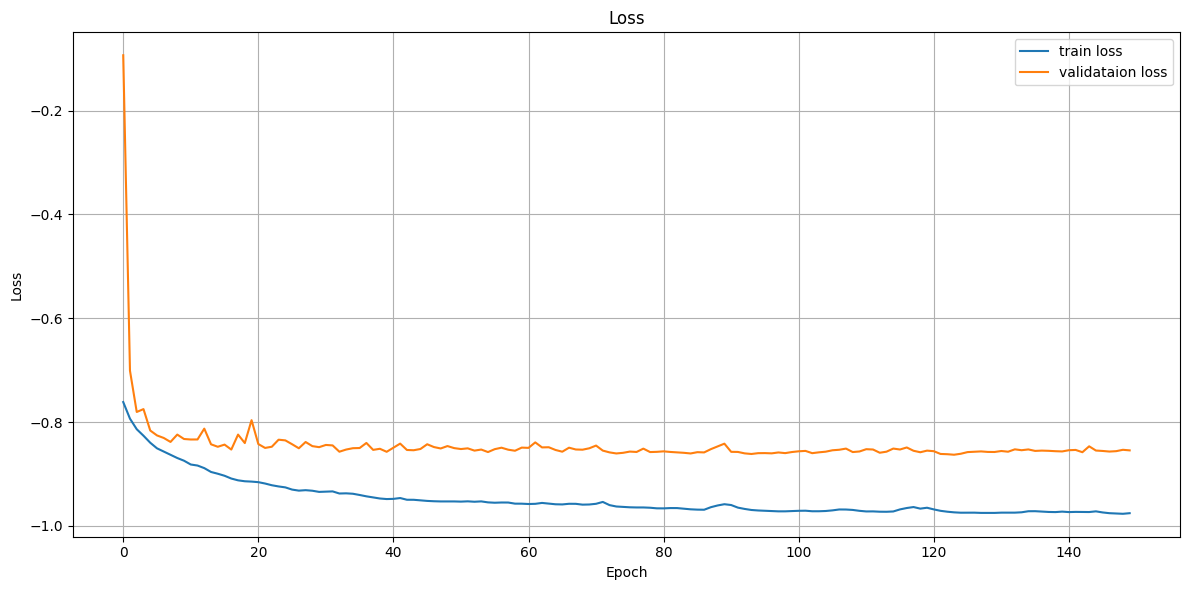

In [32]:
display_learning_curves(model.history)

In [33]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [34]:
def display(display_list, dice):
  plt.figure(figsize=(15, 15))
  title = ["Input Image", "True Mask", f"Predicted Mask(dice={dice:.3f})"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis("off")
  plt.show()

In [35]:
dice_coef = DiceCoefficient()

def show_predictions(model, dataset, num=1):
  for image, mask in dataset.take(num):
    pred_mask = model.predict(image)
    dice = dice_coef.call(mask, pred_mask)
    display([image[0], mask[0], pred_mask[0]], np.abs(dice[0]))


In [36]:
count = 0
for i in test_dataset:
    count +=1
print("number of batches:", count)

number of batches: 552


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


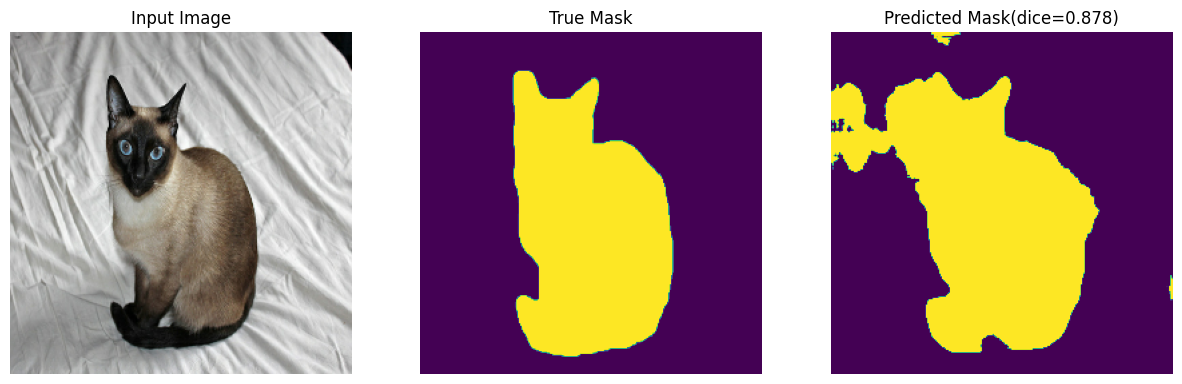

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


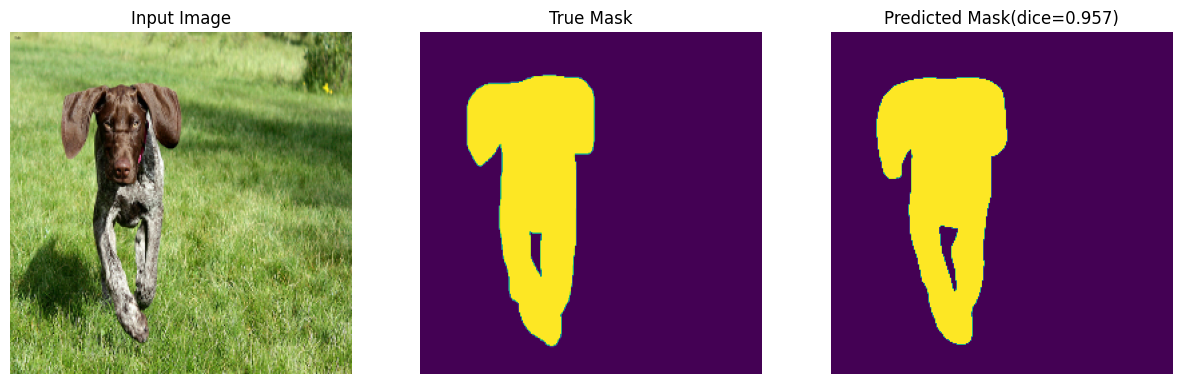

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


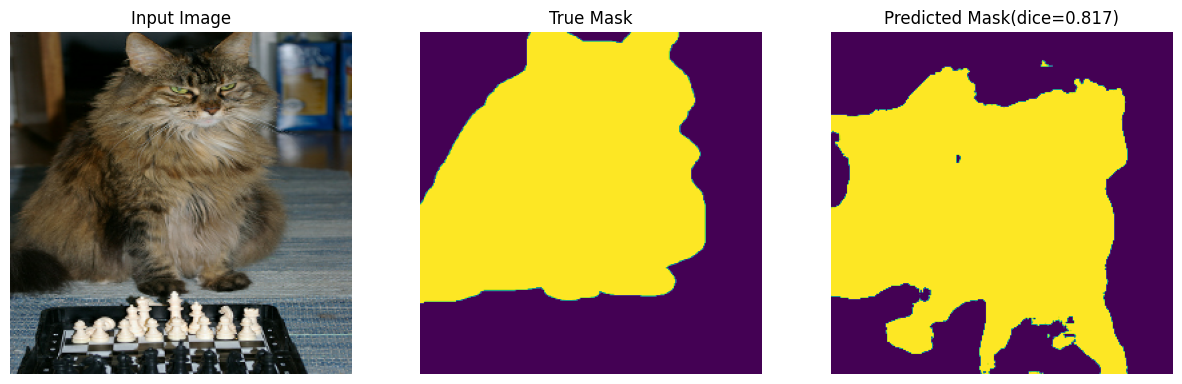

In [42]:
show_predictions(model, test.skip(5), 3)

In [38]:
dice_coef = DiceCoefficient()
def calculate_dice_values(model, dataset):
  dice_values = []
  for image, mask in dataset:
    pred_mask = model.predict(image, verbose=0)
    [dice_values.append(dice_coef.call(mask[i], pred_mask[i])) for i in range(mask.shape[0])]
  return np.array(dice_values)


def calc_avg_dice(model, dataset):
  dice_values = calculate_dice_values(model, dataset)
  mean_dice = dice_values.mean()
  normal_esc_seq = "\u001b[0m"
  bold_esc_seq = "\u001b[1m"
  magenta_esc_seq = "\u001b[35m"
  print(f"{magenta_esc_seq}================\n {bold_esc_seq}Mean dice:{np.abs(mean_dice):.3f} {normal_esc_seq}{magenta_esc_seq}\n================\n")
  return np.abs(mean_dice)


In [39]:
mean_dice = calc_avg_dice(model, test)

 Mean dice:0.818 



In [43]:
from datetime import datetime
model_path = f"oxford_pet_model_no_border{datetime.now()}_dice{mean_dice:.3f}.keras"

In [44]:
model.save(filepath = model_path)